In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
X = np.load('X.npy')
# Y = np.load('Y.npy')

# flatten the X matrix
X = X.reshape(X.shape[0], -1)

Y = np.zeros((X.shape[0], 10))
Y[0:204, 9] = 1
Y[204:409, 0] = 1
Y[409:615, 7] = 1
Y[615:822, 6] = 1
Y[822:1028, 1] = 1
Y[1028:1236, 8] = 1
Y[1236:1443, 4] = 1
Y[1443:1649, 3] = 1
Y[1649:1855, 2] = 1
Y[1855:, 5] = 1

indices = np.argmax(Y, axis=1)
Y = np.expand_dims(indices, axis=1)


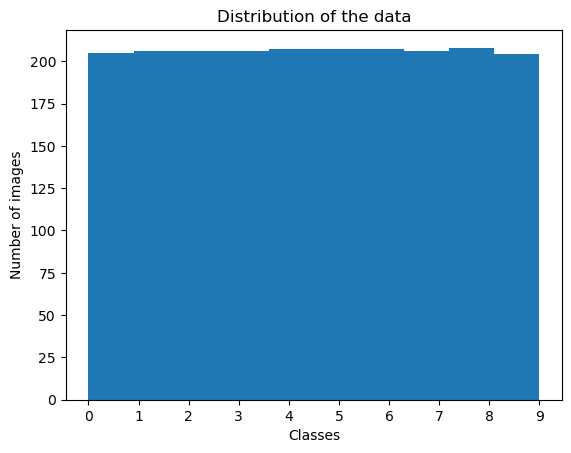

In [3]:
# plot the distribution of the data
plt.hist(Y)
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Distribution of the data')
plt.xticks(np.arange(10))
plt.show()

In [4]:
# Split data into train and test

data = np.concatenate((Y, X), axis=1)

np.random.shuffle(data)

# data = data.T

# Y = data[0] # every column is the label of the image at the same column in X
# X = data[1:] # every column is an image and every row is a pixel of that image

# X_train = X[:, 0:2000]
# Y_train = Y[0:2000]

# X_test = X[:, 2000:]
# Y_test = Y[2000:]

# Y_train = Y_train.reshape(Y_train.shape[0], 1)
# Y_test = Y_test.reshape(Y_test.shape[0], 1)

Y = data[:, 0]
X = data[:, 1:]

X_train = X[0:2000]
Y_train = Y[0:2000]

X_test = X[2000:]
Y_test = Y[2000:]

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)


In [5]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in+1) *(2*epi) -epi
    
    return W


In [6]:
input_layer_size  = 4096
hidden_layer_size = 20
num_labels = 10

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
def ReLU(y):
    return np.maximum(0, y)

In [9]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigGrad = sigmoid(z) * (1 - sigmoid(z))
    
    return sigGrad

In [10]:
def softmax(z):
    """
    computes the softmax function
    """
    exp = np.exp(z)
    exp_sum = np.sum(exp, axis=0)
    return exp/exp_sum

### PART 3: Neural Network training to predict the digit

**Objectives**: Implement Backpropagation algorithm for NN training to the task of hand-written digit recognition.

**NN cost function:** 
$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j,k}^{(2)})^2]$

*nnCostFunction* computes the NN cost (above) and the gradients with and without regularization.

In [11]:
def nnCostFunction(theta1, theta2,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """

    m = X.shape[0] # number of training examples = 2000
    J = 0
    y10 = np.zeros((m, num_labels)) # 2000x10
    for i in range(num_labels):
        y10[:,i][:,np.newaxis] = np.where(y==i,1,0)

    X = np.hstack((np.ones((m,1)),X)) # 2000x4097

    a1 = sigmoid(X @ theta1.T) # 2000x4097 * 4097x10 = 2000x10
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer -> 2000x11
    a2 = sigmoid(a1 @ theta2.T) # output layer -> 2000x11 * 11x10 = 2000x10

    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))

    cost = 1/m * J
    reg_J = cost + Lambda/(2*m) * (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))

    # Implement the backpropagation algorithm to compute the gradients

    grad1 = np.zeros((theta1.shape)) # 10x4097
    grad2 = np.zeros((theta2.shape)) # 10x11

    for i in range(m):
        xi= X[i,:] # 4097x1
        a1i = a1[i,:] # 11x1
        a2i = a2[i,:] # 10x1
        d2 = a2i - y10[i,:] # 10x1
        d1 = theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ theta1.T))) # 11x11
        grad1 = grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T # 10x1 * 1x4097 = 10x4097
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T # 10x1 * 1x11 = 10x11

    grad1 = 1/m * grad1
    grad2 = 1/m * grad2

    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((theta1.shape[0],1)),theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((theta2.shape[0],1)),theta2[:,1:]))

    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [12]:
# cost, grad1, grad2, reg_J, grad1_reg, grad2_reg = nnCostFunction(initial_Theta1, initial_Theta2, input_layer_size, hidden_layer_size, num_labels, X_train, Y_train, 0.1)

def gradientDescentnn(X,y,initial_theta1, initial_theta2,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy arra
    y X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    m = X.shape[0]
    theta1 = initial_theta1
    theta2 = initial_theta2
    J_history = []

    # prev_cost = float('inf')

    for i in range(num_iters):
        cost, grad1, grad2, reg_J, grad1_reg, grad2_reg = nnCostFunction(theta1, theta2,input_layer_size, hidden_layer_size, num_labels,X,y,Lambda)
        # theta1 = theta1 - (alpha * grad1)
        # theta2 = theta2 - (alpha * grad2)
        theta1 = theta1 - (alpha * grad1_reg)
        theta2 = theta2 - (alpha * grad2_reg)
        if i % 10 == 0:
            print('Cost at iteration',i,':',cost)
            print('Regularized cost at iteration',i,':',reg_J)
            # if prev_cost - reg_J < 0.0001:
            #     print('Converged at iteration',i,':',reg_J)
            #     break

        # prev_cost = cost
        
        # J_history.append(cost)
        J_history.append(reg_J)

    return theta1, theta2, J_history

In [13]:
alpha = 0.1
num_iters = 2000
Lambda = 0.1
num_labels = 10

theta1, theta2, J_history = gradientDescentnn(X_train,Y_train,initial_Theta1, initial_Theta2,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Cost at iteration 0 : 6.9905717235998255
Regularized cost at iteration 0 : 6.990575952267132
Cost at iteration 10 : 3.2805055669291217
Regularized cost at iteration 10 : 3.280567797030224
Cost at iteration 20 : 3.251436311412605
Regularized cost at iteration 20 : 3.2515101774242923
Cost at iteration 30 : 3.250669209121231
Regularized cost at iteration 30 : 3.2507450296770224
Cost at iteration 40 : 3.2506114685228202
Regularized cost at iteration 40 : 3.250687629059822
Cost at iteration 50 : 3.250571546654365
Regularized cost at iteration 50 : 3.2506477706675607
Cost at iteration 60 : 3.2505276066460373
Regularized cost at iteration 60 : 3.2506038482997615
Cost at iteration 70 : 3.2504775100190018
Regularized cost at iteration 70 : 3.2505537638388584
Cost at iteration 80 : 3.250419505187325
Regularized cost at iteration 80 : 3.250495773137898
Cost at iteration 90 : 3.2503515573881288
Regularized cost at iteration 90 : 3.2504278432534957
Cost at iteration 100 : 3.2502712685109545
Regular

Text(0.5, 1.0, 'Cost function using Gradient Descent')

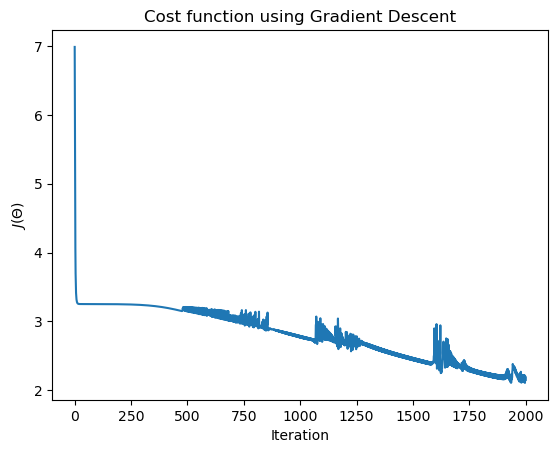

In [14]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(J_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [15]:
def predict(theta1, theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    #number of training examples
    m= len(X)
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)),X,axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, theta1.T)  #Inputs to the hidden layer neurons
    a1=sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, theta2.T) #Inputs to the output layer neurons
    a2=sigmoid(z2)  #Outputs  of the output layer neurons

    return np.argmax(a2,axis=1)

In [16]:
pred = predict(theta1, theta2, X_test)

print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == Y_test.ravel())*100))

Training Set Accuracy: 50.0%
